In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pat
import statsmodels.api as sm

# **Why Normative Modeling?**

## **Context**

- Currently, there are no biological tests to diagnose psychiatric disorders. They are diagnosed using clinical symptoms, which leads heterogeneous groups on the biological level.
- The overwhelming majority of analysis in psychiatry & neuroimaging is focussed on group averages, which ignore individual differences.
- This leads to losing information about individual subjects and missing patterns that aren't consistent across the entire group.

From Marquand et al. 2016:

![image1](image1.jpg)

>The classical case-control approach assumes that cases and controls each form a well-defined group. This may often be a reasonable assumption, but in practice many other scenarios are possible. 
>- A Cases and controls each form a well-defined group
>- B The clinical population may be composed of multiple groups, each having distinct pathology 
>- C Disease-related variation may be nested within healthy variation
>- D The clinical group may be diffuse and heterogeneous as a result of misdiagnosis, comorbidities, or an aggregation of different pathologies.

## **Example where case-control fails**
We'll construct an example in which:
- We know there is a difference between probands and controls (as we've created it)
- Case-control analysis misses it

### Generate Data
First we generate the data:
- We model score = 2*log(age) + gaussian noise
- Probands have a random offset to their score
- Probands are not distributed evenly throughout the dataset

In [2]:
# Define Functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x
    
def f(x):
    return 2*np.log(x) + np.random.randn()

def dataset(seed=10,sampling='full'):
    # Set seed
    np.random.seed(seed)

    # Age param
    x = np.sort(sample_x(sampling=sampling))

    # PROB = 1/CTR = 0
    status1 =  np.random.binomial(1,0.2,size=(int(0.75*x.shape[0])))
    status2 =  np.random.binomial(1,0.07,size=(x.shape[0] - status1.shape[0]))
    status = np.concatenate([status1, status2])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = f(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    return pd.DataFrame([x,status,score],index=['age','status','score']).transpose()

In [3]:
# Create a dataset
df = dataset()
df.head()

,age,status,score
0,1.174205,0.0,1.733340
1,1.329895,1.0,0.201192
2,1.390878,0.0,2.098539
3,1.418167,0.0,0.034777
4,1.436357,0.0,0.509641


### Visualize data
- CTR = 0
- PROB = 1

We can see below that extreme scores for a given age are more frequently probands.

<AxesSubplot:xlabel='age', ylabel='score'>

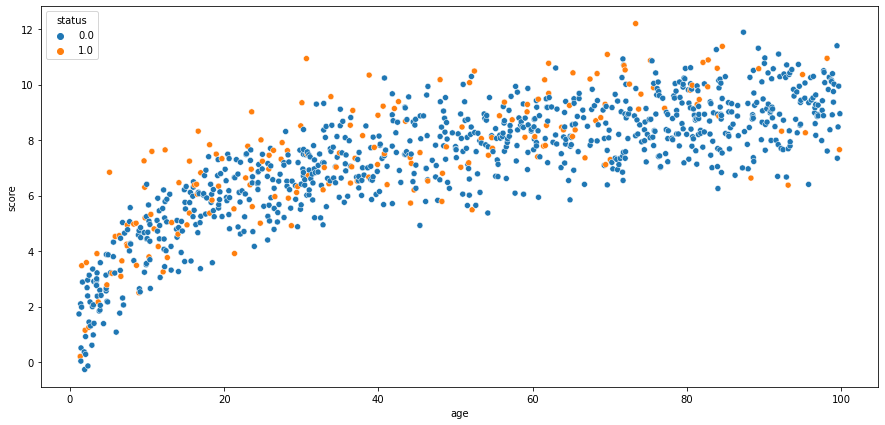

In [4]:
plt.figure(figsize=(15,7))
sns.scatterplot(x='age',y='score',hue='status',data=df)

### Case-control

- Here we perform a simple case-control analysis using the status column of the dataset (PROB/CTR).
- The result is not significant (p = 0.99)

In [5]:
def case_control(df, group='status',score='score'):
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe',NA_action='raise')
    results = sm.OLS(df[score],dmat).fit()
    return results.pvalues[1]


In [6]:
print('p-value =', case_control(df))

p-value = 0.8760719899903657


# **Normative Modeling**
- Normative modeling looks at how individuals deviate from the normal trajectory rather than group averages between probands and controls
- Permits the detection and mapping of distinct patterns of abnormality in individuals without requiring a consistent neurobiological signature across all individuals
- Recasts disease as an extreme of the normal range or as a deviation from normal

Here is an example application of normative modeling to multivoxel neuroimaging data from Marquand et al 2016:

![image2](image2.jpg)

# **PyNM**

PyNM is a lightweight python implementation of normative modeling, that makes available four different models. It is intended to make it easy to try different approaches and check their validity. In this series of tutorials we will:
- Explore using PyNM for normative modeling
- Explain the basic underlying concepts
- Discuss when to use which model

# **Resources**
Normative modeling methods papers:
- Marquand et al. Biological Psychiatry 2016 [doi:10.1016/j.biopsych.2015.12.023](https://doi.org/10.1016/j.biopsych.2015.12.023)
- Rutherford et al. bioRxiv 2021 [https://doi.org/10.1101/2021.08.08.455583](https://doi.org/10.1101/2021.08.08.455583)

### **Next up:** Getting started: normative modeling with the LOESS & Centiles models!